In [451]:
import base64
import io
import pickle
import numpy as np
import torch
print(f'TORCH VERSION: {torch.__version__}') 
import packaging.version
if packaging.version.parse(torch.__version__) < packaging.version.parse('1.5.0'): raise RuntimeError('Torch versions lower than 1.5.0 not supported')
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

TORCH VERSION: 2.5.1


In [452]:
if torch.cuda.is_available():
    torch_device = 'cuda'
    float_dtype = np.float32 # single torch.set_default_tensor_type(torch.cuda.FloatTensor)
else:
    torch_device = 'cpu'
    float_dtype = np.float64 # double torch.set_default_tensor_type(torch.DoubleTensor)
print(f"TORCH DEVICE: {torch_device}")

TORCH DEVICE: cpu


In [453]:
def torch_mod(x):
    return torch.remainder(x, 2*np.pi)
def torch_wrap(x):
    return torch_mod(x+np.pi) - np.pi

In [454]:
def grab(var):
    return var.detach().cpu().numpy()

In [455]:
from IPython.display import display
def init_live_plot(dpi=125, figsize=(8,4)):
    fig, ax_ess = plt.subplots(1,1, dpi=dpi, figsize=figsize)
    plt.xlim(0, N_era*N_epoch)
    plt.ylim(0, 1)

    ess_line = plt.plot([0],[0], alpha=0.5) # dummy plt.grid(False)
    plt.ylabel('ESS')

    ax_loss = ax_ess.twinx()
    loss_line = plt.plot([0],[0], alpha=0.5, c='orange') # dummy plt.grid(False)
    plt.ylabel('Loss')
    
    plt.xlabel('Epoch')
    
    display_id = display(fig, display_id=True)
    
    return dict(
        fig=fig, ax_ess=ax_ess, ax_loss=ax_loss,
        ess_line=ess_line, loss_line=loss_line,
        display_id=display_id
)

def moving_average(x, window=10):
    if len(x) < window:
        return np.mean(x, keepdims=True)
    else:
        return np.convolve(x, np.ones(window), 'valid') / window

def update_plots(history, fig, ax_ess, ax_loss, ess_line, loss_line, display_id): 
    Y = np.array(history['ess'])
    Y = moving_average(Y, window=15)
    ess_line[0].set_ydata(Y)
    ess_line[0].set_xdata(np.arange(len(Y))) 
    Y = history['loss']
    Y = moving_average(Y, window=15) 
    loss_line[0].set_ydata(np.array(Y)) 
    loss_line[0].set_xdata(np.arange(len(Y))) 
    ax_loss.relim()
    ax_loss.autoscale_view()
    fig.canvas.draw()
    display_id.update(fig) # need to force colab to update plot

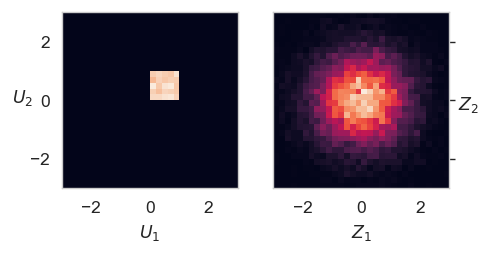

In [456]:
batch_size = 2**14
u = np.random.random(size=(batch_size, 2))
z = np.sqrt(-2*np.log(u[:,0]))[:,np.newaxis] * np.stack(
    (np.cos(2*np.pi*u[:,1]), np.sin(2*np.pi*u[:,1])), axis=-1)
fig, ax = plt.subplots(1,2, dpi=125, figsize=(4,2))
for a in ax:
    a.set_xticks([-2, 0, 2]) 
    a.set_yticks([-2, 0, 2]) 
    a.set_aspect('equal')
ax[0].hist2d(u[:,0], u[:,1], bins=30, range=[[-3.0,3.0], [-3.0,3.0]])
ax[0].set_xlabel(r"$U_1$")
ax[0].set_ylabel(r"$U_2$", rotation=0, y=.46)
ax[1].hist2d(z[:,0], z[:,1], bins=30, range=[[-3.0,3.0], [-3.0,3.0]])
ax[1].set_yticklabels([])
ax[1].set_xlabel(r"$Z_1$")
ax[1].set_ylabel(r"$Z_2$", rotation=0, y=.53)
ax[1].yaxis.set_label_position("right")
ax[1].yaxis.tick_right()
plt.show()

In [457]:
class SimpleNormal:
    def __init__(self, loc, var):
        self.dist = torch.distributions.normal.Normal(
            torch.flatten(loc), torch.flatten(var))
        self.shape = loc.shape
    def log_prob(self, x):
        logp = self.dist.log_prob(x.reshape(x.shape[0], -1))
        return torch.sum(logp, dim=1)
    def sample_n(self, batch_size):
        x = self.dist.sample((batch_size,))
        return x.reshape(batch_size, *self.shape)

In [458]:
normal_prior = SimpleNormal(torch.zeros((3,4,5)), torch.ones((3,4,5))) 
z = normal_prior.sample_n(17)
print(f'z.shape = {z.shape}')
print(f'log r(z) = {grab(normal_prior.log_prob(z))}')

z.shape = torch.Size([17, 3, 4, 5])
log r(z) = [-83.09745  -85.52499  -80.15467  -83.03071  -72.81555  -89.249466
 -79.4142   -83.99666  -76.03828  -89.217766 -80.79142  -79.834915
 -84.99463  -83.431885 -90.0626   -86.198616 -90.03276 ]


In [459]:
class SimpleCouplingLayer(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.s = torch.nn.Sequential(
            torch.nn.Linear(1, 8),
            torch.nn.ReLU(),
            torch.nn.Linear(8, 8),
            torch.nn.ReLU(),
            torch.nn.Linear(8, 1),
            torch.nn.Tanh()
        ).double()
    def forward(self, x):
        x1, x2 = x[:,0], x[:,1]
        s = self.s(x2.unsqueeze(-1)).squeeze(-1)
        fx1 = torch.exp(s) * x1
        fx2 = x2
        logJ = s
        return torch.stack((fx1, fx2), dim=-1), logJ
    def reverse(self, fx):
        fx1, fx2 = fx[:,0], fx[:,1]
        x2 = fx2
        s = self.s(x2.unsqueeze(-1)).squeeze(-1)
        logJ = -s
        x1 = torch.exp(-s) * fx1
        return torch.stack((x1, x2), dim=-1), logJ
coupling_layer = SimpleCouplingLayer()
# init weights in a way that gives interesting behavior without training
def set_weights(m):
    if hasattr(m, 'weight') and m.weight is not None:
        torch.nn.init.normal_(m.weight, mean=1, std=2) 
    if hasattr(m, 'bias') and m.bias is not None:
        m.bias.data.fill_(-1)
torch.manual_seed(1234)
coupling_layer.s.apply(set_weights);

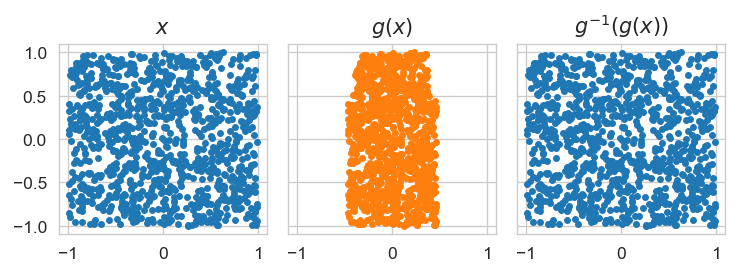

In [460]:
batch_size = 1024
np_x = (2*np.random.random(size=(batch_size, 2)) - 1).astype(float_dtype)
x = torch.from_numpy(np_x).to(torch_device)
gx, fwd_logJ = coupling_layer.forward(x)
xp, bwd_logJ = coupling_layer.reverse(gx)
fig, ax = plt.subplots(1,3, dpi=125, figsize=(6,2.3), sharex=True, sharey=True)
np_gx, np_xp = grab(gx), grab(xp)
for a in ax:
    a.set_xlim(-1.1,1.1)
    a.set_ylim(-1.1,1.1)
ax[0].scatter(np_x[:,0], np_x[:,1], marker='.') 
ax[0].set_title(r'$x$')
ax[1].scatter(np_gx[:,0], np_gx[:,1], marker='.', color='tab:orange') 
ax[1].set_title(r'$g(x)$')
ax[2].scatter(np_xp[:,0], np_xp[:,1], marker='.') 
ax[2].set_title(r"$g^{-1}(g(x))$")
fig.set_tight_layout(True)
plt.show()

In [461]:
def apply_flow_to_prior(prior, coupling_layers, *, batch_size):
    x = prior.sample_n(batch_size)
    logq = prior.log_prob(x)
    for layer in coupling_layers:
        x, logJ = layer.forward(x)
        logq = logq - logJ
    return x, logq

In [462]:
L=8
lattice_shape = (L,L)
phi_ex1 = np.random.normal(size=lattice_shape).astype(float_dtype)
phi_ex2 = np.random.normal(size=lattice_shape).astype(float_dtype)
cfgs = torch.from_numpy(np.stack((phi_ex1, phi_ex2), axis=0)).to(torch_device)

In [463]:
class ScalarPhi4Action:
    def __init__(self, M2, lam):
        self.M2 = M2
        self.lam = lam
    def __call__(self, cfgs):
        # potential term
        action_density = self.M2*cfgs**2 + self.lam*cfgs**4 
        # kinetic term (discrete Laplacian)
        Nd = len(cfgs.shape)-1
        dims = range(1,Nd+1)
        for mu in dims:
            action_density += 2*cfgs**2
            action_density -= cfgs*torch.roll(cfgs, -1, mu)
            action_density -= cfgs*torch.roll(cfgs, 1, mu)
        return torch.sum(action_density, dim=tuple(dims))
print("Actions for example configs:", ScalarPhi4Action(M2=1.0, lam=1.0)(cfgs))

Actions for example configs: tensor([638.7964, 616.0258], dtype=torch.float64)


In [464]:
M2 = -4.0
lam = 8.0
phi4_action = ScalarPhi4Action(M2=M2, lam=lam)

In [465]:
prior = SimpleNormal(torch.zeros(lattice_shape), torch.ones(lattice_shape))

z.shape = (1024, 8, 8)


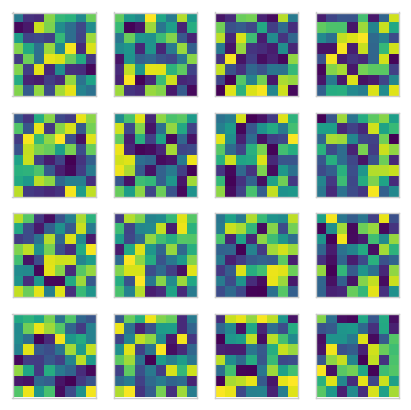

In [466]:
torch_z = prior.sample_n(1024) 
z = grab(torch_z) 
print(f'z.shape = {z.shape}')
fig, ax = plt.subplots(4,4, dpi=125, figsize=(4,4))
for i in range(4):
    for j in range(4):
        ind = i*4 + j
        ax[i,j].imshow(np.tanh(z[ind]), vmin=-1, vmax=1, cmap='viridis') 
        ax[i,j].axes.xaxis.set_visible(False) 
        ax[i,j].axes.yaxis.set_visible(False)
plt.show()

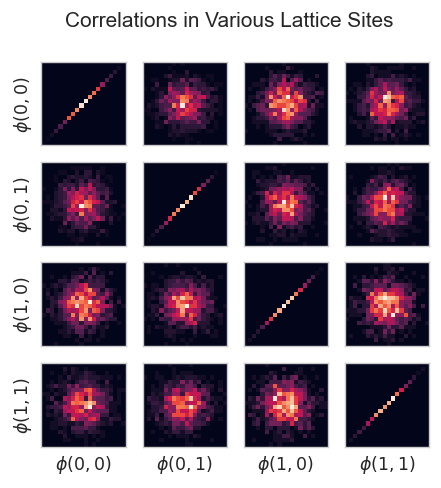

In [467]:
fig, ax = plt.subplots(4,4, dpi=125, figsize=(4,4))
for x1 in range(2):
    for y1 in range(2):
        i1 = x1*2 + y1
        for x2 in range(2):
            for y2 in range(2):
                i2 = x2*2 + y2
                ax[i1,i2].hist2d(z[:,x1,y1], z[:,x2,y2], range=[[-3,3],[-3,3]], bins=20)
                ax[i1,i2].set_xticks([])
                ax[i1,i2].set_yticks([])
                if i1 == 3:
                    ax[i1,i2].set_xlabel(rf'$\phi({x2},{y2})$') 
                if i2 == 0:
                    ax[i1,i2].set_ylabel(rf'$\phi({x1},{y1})$') 
fig.suptitle("Correlations in Various Lattice Sites")
plt.show()

slope 1 linear regression S = -logr + 1463.1442


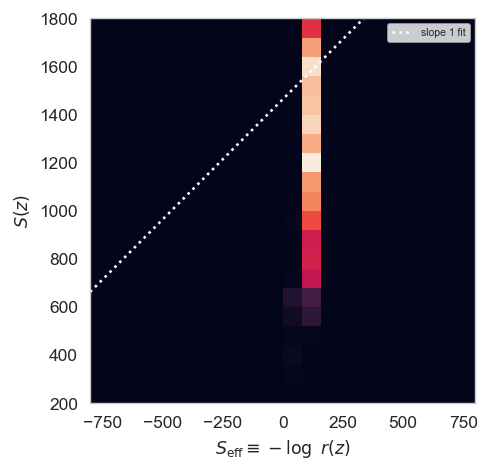

In [468]:
S_eff = -grab(prior.log_prob(torch_z))
S = grab(phi4_action(torch_z))
fit_b = np.mean(S) - np.mean(S_eff)
print(f'slope 1 linear regression S = -logr + {fit_b:.4f}') 
fig, ax = plt.subplots(1,1, dpi=125, figsize=(4,4)) 
ax.hist2d(S_eff, S, bins=20, range=[[-800, 800], [200,1800]]) 
xs = np.linspace(-800, 800, num=4, endpoint=True)
ax.plot(xs, xs + fit_b, ':', color='w', label='slope 1 fit') 
ax.set_xlabel(r'$S_{\mathrm{eff}} \equiv -\log~r(z)$') 
ax.set_ylabel(r'$S(z)$')
ax.set_aspect('equal')
plt.legend(prop={'size': 6}) 
plt.show()

In [469]:
def make_checker_mask(shape, parity):
    checker = torch.ones(shape, dtype=torch.uint8) - parity
    checker[::2, ::2] = parity
    checker[1::2, 1::2] = parity
    return checker.to(torch_device)
print("For example this is the mask for an 8x8 configuration:\n",
      make_checker_mask(lattice_shape, 0))

For example this is the mask for an 8x8 configuration:
 tensor([[0, 1, 0, 1, 0, 1, 0, 1],
        [1, 0, 1, 0, 1, 0, 1, 0],
        [0, 1, 0, 1, 0, 1, 0, 1],
        [1, 0, 1, 0, 1, 0, 1, 0],
        [0, 1, 0, 1, 0, 1, 0, 1],
        [1, 0, 1, 0, 1, 0, 1, 0],
        [0, 1, 0, 1, 0, 1, 0, 1],
        [1, 0, 1, 0, 1, 0, 1, 0]], dtype=torch.uint8)


In [470]:
class AffineCoupling(torch.nn.Module):
    def __init__(self, net, *, mask_shape, mask_parity):
        super().__init__()
        self.mask = make_checker_mask(mask_shape, mask_parity)
        self.net = net
    def forward(self, x):
        x_frozen = self.mask * x
        x_active = (1 - self.mask) * x
        net_out = self.net(x_frozen.unsqueeze(1))
        s, t = net_out[:,0], net_out[:,1]
        fx = (1 - self.mask) * t + x_active * torch.exp(s) + x_frozen
        axes = range(1,len(s.size()))
        logJ = torch.sum((1 - self.mask) * s, dim=tuple(axes))
        return fx, logJ
    def reverse(self, fx):
        fx_frozen = self.mask * fx
        fx_active = (1 - self.mask) * fx
        net_out = self.net(fx_frozen.unsqueeze(1))
        s, t = net_out[:,0], net_out[:,1]
        x = (fx_active - (1 - self.mask) * t) * torch.exp(-s) + fx_frozen
        axes = range(1,len(s.size()))
        logJ = torch.sum((1 - self.mask)*(-s), dim=tuple(axes))
        return x, logJ

In [471]:
def make_conv_net(*, hidden_sizes, kernel_size, in_channels, out_channels, use_final_tanh): 
    sizes = [in_channels] + hidden_sizes + [out_channels]
    assert packaging.version.parse(torch.__version__) >= packaging.version.parse('1.5.0') 
    assert kernel_size % 2 == 1, 'kernel size must be odd for PyTorch >= 1.5.0' 
    padding_size = (kernel_size // 2)
    net = []
    for i in range(len(sizes) - 1):
        net.append(torch.nn.Conv2d(
            sizes[i], sizes[i+1], kernel_size, padding=padding_size, 
            stride=1, padding_mode='circular'))
        if i != len(sizes) - 2:
            net.append(torch.nn.LeakyReLU())
        else:
            if use_final_tanh:
                net.append(torch.nn.Tanh())
    return torch.nn.Sequential(*net)

In [472]:
def make_phi4_affine_layers(*, n_layers, lattice_shape, hidden_sizes, kernel_size):
    layers = []
    for i in range(n_layers):
        parity = i % 2
        net = make_conv_net(
            in_channels=1, out_channels=2, hidden_sizes=hidden_sizes,
            kernel_size=kernel_size, use_final_tanh=True)
        coupling = AffineCoupling(net, mask_shape=lattice_shape, mask_parity=parity)
        layers.append(coupling)
    return torch.nn.ModuleList(layers)

In [473]:
n_layers = 16
hidden_sizes = [8,8]
kernel_size = 3
layers = make_phi4_affine_layers(
    lattice_shape=lattice_shape, n_layers=n_layers,
hidden_sizes=hidden_sizes, kernel_size=kernel_size) 
model = {'layers': layers, 'prior': prior}

In [474]:
def calc_dkl(logp, logq):
    return (logq - logp).mean() # reverse KL, assuming samples from q

In [475]:
def train_step(model, action, loss_fn, optimizer, metrics): 
    layers, prior = model['layers'], model['prior'] 
    optimizer.zero_grad()
    x, logq = apply_flow_to_prior(prior, layers, batch_size=batch_size)
    logp = -action(x)
    loss = calc_dkl(logp, logq)
    loss.backward()
    optimizer.step()
    metrics['loss'].append(grab(loss)) 
    metrics['logp'].append(grab(logp)) 
    metrics['logq'].append(grab(logq))
    metrics['ess'].append(grab( compute_ess(logp, logq) ))

In [476]:
def compute_ess(logp, logq):
    logw = logp - logq
    log_ess = 2*torch.logsumexp(logw, dim=0) - torch.logsumexp(2*logw, dim=0)
    ess_per_cfg = torch.exp(log_ess) / len(logw)
    return ess_per_cfg

In [477]:
def print_metrics(history, avg_last_N_epochs): 
    print(f'== Era {era} | Epoch {epoch} metrics ==') 
    for key, val in history.items():
        avgd = np.mean(val[-avg_last_N_epochs:]) 
        print(f'\t{key} {avgd:g}')

In [478]:
use_pretrained = False

In [479]:
# Lattice Theory
L=8
lattice_shape = (L,L)
M2 = -4.0
lam = 8.0
phi4_action = ScalarPhi4Action(M2=M2, lam=lam)
# Model
prior = SimpleNormal(torch.zeros(lattice_shape), torch.ones(lattice_shape))
n_layers = 16
hidden_sizes = [8,8]
kernel_size = 3
layers = make_phi4_affine_layers(lattice_shape=lattice_shape, n_layers=n_layers,
                                 hidden_sizes=hidden_sizes, kernel_size=kernel_size) 
model = {'layers': layers, 'prior': prior}
# Training
base_lr = .001
optimizer = torch.optim.Adam(model['layers'].parameters(), lr=base_lr)

In [480]:
if use_pretrained:
    print('Loading pre-trained model')
    phi4_trained_weights = torch.load(io.BytesIO(base64.b64decode(b"""<snipped base64 blob>""".strip())), map_location=torch.device('cpu')) 
    model['layers'].load_state_dict(phi4_trained_weights) 
    if torch_device == 'cuda':
        model['layers'].cuda()
else:
    print('Skipping pre-trained model')

Skipping pre-trained model


In [481]:
N_era = 25
N_epoch = 100
batch_size = 64
print_freq = N_epoch
plot_freq = 1
history = { 'loss' : [],
'logp' : [], 'logq' : [], 'ess' : []
}

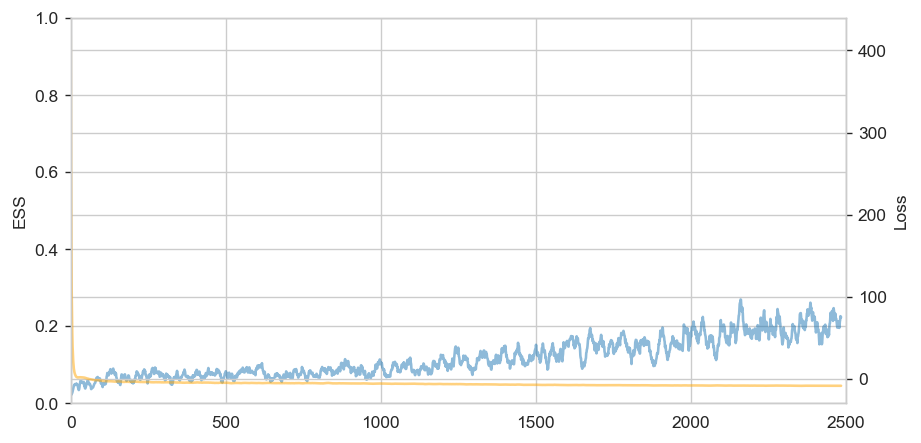

== Era 0 | Epoch 0 metrics ==
	loss 2414.13
	logp -2496.26
	logq -82.1294
	ess 0.0171147
== Era 1 | Epoch 0 metrics ==
	loss 39.6145
	logp -56.4838
	logq -16.8692
	ess 0.0463501
== Era 2 | Epoch 0 metrics ==
	loss -2.73848
	logp -13.2388
	logq -15.9773
	ess 0.0666038
== Era 3 | Epoch 0 metrics ==
	loss -3.41448
	logp -12.904
	logq -16.3184
	ess 0.0730708
== Era 4 | Epoch 0 metrics ==
	loss -4.00317
	logp -12.8565
	logq -16.8596
	ess 0.0679084
== Era 5 | Epoch 0 metrics ==
	loss -4.2041
	logp -12.8591
	logq -17.0633
	ess 0.0740916
== Era 6 | Epoch 0 metrics ==
	loss -4.57021
	logp -12.7391
	logq -17.3094
	ess 0.0780408
== Era 7 | Epoch 0 metrics ==
	loss -4.69243
	logp -12.7327
	logq -17.4251
	ess 0.0757173
== Era 8 | Epoch 0 metrics ==
	loss -4.79464
	logp -12.6656
	logq -17.4602
	ess 0.0755045
== Era 9 | Epoch 0 metrics ==
	loss -4.97137
	logp -12.6226
	logq -17.594
	ess 0.0873544
== Era 10 | Epoch 0 metrics ==
	loss -5.25964
	logp -12.528
	logq -17.7876
	ess 0.0829992
== Era 11 | Epo

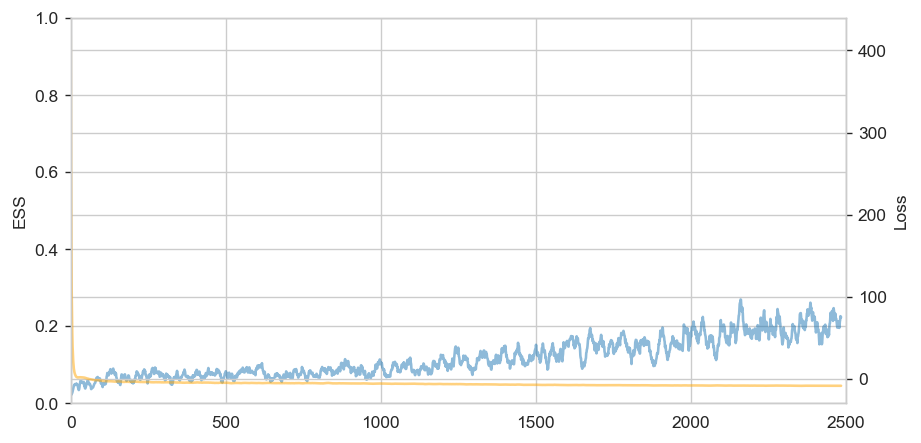

In [482]:
if not use_pretrained:
    [plt.close(plt.figure(fignum)) for fignum in plt.get_fignums()] # close all existing figures 
    live_plot = init_live_plot()
    for era in range(N_era):
        for epoch in range(N_epoch):
            train_step(model, phi4_action, calc_dkl, optimizer, history)
            if epoch % print_freq == 0:
                print_metrics(history, avg_last_N_epochs=print_freq)
            if epoch % plot_freq == 0:
                update_plots(history, **live_plot)
else:
    print('Skipping training')

In [483]:
print('Model weights blob:\n===')
serialized_model = io.BytesIO() 
torch.save(model['layers'].state_dict(), serialized_model) 
print(base64.b64encode(serialized_model.getbuffer()).decode('utf-8')) 
print('===')

Model weights blob:
===
UEsDBAAACAgAAAAAAAAAAAAAAAAAAAAAAAAQABIAYXJjaGl2ZS9kYXRhLnBrbEZCDgBaWlpaWlpaWlpaWlpaWoACY2NvbGxlY3Rpb25zCk9yZGVyZWREaWN0CnEAKVJxAShYDgAAADAubmV0LjAud2VpZ2h0cQJjdG9yY2guX3V0aWxzCl9yZWJ1aWxkX3RlbnNvcl92MgpxAygoWAcAAABzdG9yYWdlcQRjdG9yY2gKRmxvYXRTdG9yYWdlCnEFWAEAAAAwcQZYAwAAAGNwdXEHS0h0cQhRSwAoSwhLAUsDSwN0cQkoSwlLCUsDSwF0cQqJaAApUnELdHEMUnENWAwAAAAwLm5ldC4wLmJpYXNxDmgDKChoBGgFWAEAAAAxcQ9oB0sIdHEQUUsASwiFcRFLAYVxEoloAClScRN0cRRScRVYDgAAADAubmV0LjIud2VpZ2h0cRZoAygoaARoBVgBAAAAMnEXaAdNQAJ0cRhRSwAoSwhLCEsDSwN0cRkoS0hLCUsDSwF0cRqJaAApUnEbdHEcUnEdWAwAAAAwLm5ldC4yLmJpYXNxHmgDKChoBGgFWAEAAAAzcR9oB0sIdHEgUUsASwiFcSFLAYVxIoloAClScSN0cSRScSVYDgAAADAubmV0LjQud2VpZ2h0cSZoAygoaARoBVgBAAAANHEnaAdLkHRxKFFLAChLAksISwNLA3RxKShLSEsJSwNLAXRxKoloAClScSt0cSxScS1YDAAAADAubmV0LjQuYmlhc3EuaAMoKGgEaAVYAQAAADVxL2gHSwJ0cTBRSwBLAoVxMUsBhXEyiWgAKVJxM3RxNFJxNVgOAAAAMS5uZXQuMC53ZWlnaHRxNmgDKChoBGgFWAEAAAA2cTdoB0tIdHE4UUsAKEsISwFLA0sDdHE5KEsJSwlLA0sBdHE6iWgAKVJxO3RxPFJxPVgMAAAAMS5uZXQuMC5iaWFzcT5o

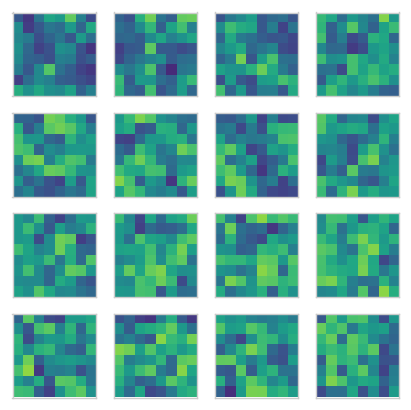

In [484]:
torch_x, torch_logq = apply_flow_to_prior(prior, layers, batch_size=1024)
x = grab(torch_x)
fig, ax = plt.subplots(4,4, dpi=125, figsize=(4,4))
for i in range(4):
    for j in range(4):
        ind = i*4 + j
        ax[i,j].imshow(np.tanh(x[ind]), vmin=-1, vmax=1, cmap='viridis') 
        ax[i,j].axes.xaxis.set_visible(False) 
        ax[i,j].axes.yaxis.set_visible(False)
plt.show()

slope 1 linear regression S = S_eff + -7.9982


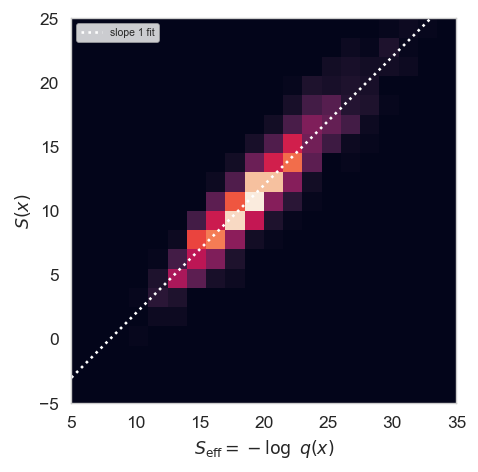

In [485]:
S_eff = -grab(torch_logq)
S = grab(phi4_action(torch_x))
fit_b = np.mean(S) - np.mean(S_eff)
print(f'slope 1 linear regression S = S_eff + {fit_b:.4f}') 
fig, ax = plt.subplots(1,1, dpi=125, figsize=(4,4)) 
ax.hist2d(S_eff, S, bins=20, range=[[5, 35], [-5, 25]]) 
ax.set_xlabel(r'$S_{\mathrm{eff}} = -\log~q(x)$') 
ax.set_ylabel(r'$S(x)$')
ax.set_aspect('equal')
xs = np.linspace(5, 35, num=4, endpoint=True)
ax.plot(xs, xs + fit_b, ':', color='w', label='slope 1 fit') 
plt.legend(prop={'size': 6})
plt.show()

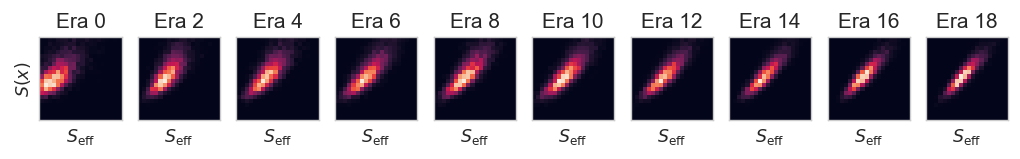

In [486]:
if not use_pretrained:
    fig, axes = plt.subplots(1, 10, dpi=125, sharey=True, figsize=(10, 1)) 
    logq_hist = np.array(history['logq']).reshape(N_era, -1)[::N_era//10] 
    logp_hist = np.array(history['logp']).reshape(N_era, -1)[::N_era//10] 
    for i, (ax, logq, logp) in enumerate(zip(axes, logq_hist, logp_hist)):
        ax.hist2d(-logq, -logp, bins=20, range=[[5, 35], [-5, 25]])
        if i == 0:
            ax.set_ylabel(r'$S(x)$') 
        ax.set_xlabel(r'$S_{\mathrm{eff}}$') 
        ax.set_title(f'Era {i * (N_era//10)}') 
        ax.set_xticks([])
        ax.set_yticks([]) 
        ax.set_aspect('equal')

    plt.show()

In [487]:
def serial_sample_generator(model, action, batch_size, N_samples): 
    layers, prior = model['layers'], model['prior']
    layers.eval()
    x, logq, logp = None, None, None
    for i in range(N_samples):
        batch_i = i % batch_size
        if batch_i == 0:
            # we're out of samples to propose, generate a new batch
            x, logq = apply_flow_to_prior(prior, layers, batch_size=batch_size) 
            logp = -action(x)
        yield x[batch_i], logq[batch_i], logp[batch_i]

In [488]:
def make_mcmc_ensemble(model, action, batch_size, N_samples):
    history = {'x' : [], 'logq' : [], 'logp' : [], 'accepted' : []}
    # build Markov chain
    sample_gen = serial_sample_generator(model, action, batch_size, N_samples)
    for new_x, new_logq, new_logp in sample_gen:
        if len(history['logp']) == 0:
            # always accept first proposal, Markov chain must start somewhere 
            accepted = True
        else:
            # Metropolis acceptance condition
            last_logp = history['logp'][-1]
            last_logq = history['logq'][-1]
            p_accept = torch.exp((new_logp - new_logq) - (last_logp - last_logq)) 
            p_accept = min(1, p_accept)
            draw = torch.rand(1) # ~ [0,1]
            if draw < p_accept:
                accepted = True
            else:
                accepted = False
                new_x = history['x'][-1] 
                new_logp = last_logp 
                new_logq = last_logq
        # Update Markov chain
        history['logp'].append(new_logp)  
        history['logq'].append(new_logq) 
        history['x'].append(new_x) 
        history['accepted'].append(accepted)
    return history

In [489]:
ensemble_size = 8192
phi4_ens = make_mcmc_ensemble(model, phi4_action, 64, ensemble_size) 
print("Accept rate:", np.mean(phi4_ens['accepted']))

Accept rate: 0.231689453125


In [490]:
n_therm = 512
cfgs = np.stack(list(map(grab, phi4_ens['x'])), axis=0)[n_therm:] 
C=0
for x in range(L):
    for y in range(L):
        C = C + cfgs*np.roll(cfgs, (-x, -y), axis=(1,2))
X = np.mean(C, axis=(1,2))
def bootstrap(x, *, Nboot, binsize):
    boots = []
    x = x.reshape(-1, binsize, *x.shape[1:])
    for i in range(Nboot):
        boots.append(np.mean(x[np.random.randint(len(x), size=len(x))], axis=(0,1)))
    return np.mean(boots), np.std(boots)
X_mean, X_err = bootstrap(X, Nboot=100, binsize=4) 
print(f'Two-point susceptibility = {X_mean:.2f} +/- {X_err:.2f}') 
print(f'... vs HMC estimate = 0.75 +/- 0.01')

Two-point susceptibility = 0.80 +/- 0.03
... vs HMC estimate = 0.75 +/- 0.01


In [491]:
L=8
lattice_shape = (L,L) 
link_shape = (2,L,L)
# some arbitrary configurations
u1_ex1 = 2*np.pi*np.random.random(size=link_shape).astype(float_dtype)
u1_ex2 = 2*np.pi*np.random.random(size=link_shape).astype(float_dtype)
cfgs = torch.from_numpy(np.stack((u1_ex1, u1_ex2), axis=0)).to(torch_device)

In [492]:
# Compute U(1) plaquettes in the (mu,nu) plane given `links` = arg(U)
def compute_u1_plaq(links, mu, nu):
    return (links[:,mu] + torch.roll(links[:,nu], -1, mu+1)
            - torch.roll(links[:,mu], -1, nu+1) - links[:,nu])

In [493]:
class U1GaugeAction:
    def __init__(self, beta):
        self.beta = beta
    def __call__(self, cfgs):
        Nd = cfgs.shape[1]
        action_density = 0
        for mu in range(Nd):
            for nu in range(mu+1,Nd):
                action_density = action_density + torch.cos(
                    compute_u1_plaq(cfgs, mu, nu))
        return -self.beta * torch.sum(action_density, dim=tuple(range(1,Nd+1)))
print(U1GaugeAction(beta=1.0)(cfgs))

tensor([ 9.4024, 10.8559], dtype=torch.float64)


In [494]:
beta = 1
u1_action = U1GaugeAction(beta)

In [495]:
def gauge_transform(links, alpha):
    for mu in range(len(links.shape[2:])):
        links[:,mu] = alpha + links[:,mu] - torch.roll(alpha, -1, mu+1)
    return links
def random_gauge_transform(x):
    Nconf, VolShape = x.shape[0], x.shape[2:]
    return gauge_transform(x, 2*np.pi*torch.rand((Nconf,) + VolShape))
# action is invariant
cfgs_transformed = random_gauge_transform(cfgs)
print(u1_action(cfgs), 'vs', u1_action(cfgs_transformed))
assert np.allclose(grab(u1_action(cfgs)), grab(u1_action(cfgs_transformed))), \
'gauge transform should be a symmetry of the action'

tensor([ 9.4024, 10.8559], dtype=torch.float64) vs tensor([ 9.4024, 10.8559], dtype=torch.float64)


In [496]:
def topo_charge(x):
    P01 = torch_wrap(compute_u1_plaq(x, mu=0, nu=1))
    axes = tuple(range(1, len(P01.shape)))
    return torch.sum(P01, dim=axes) / (2*np.pi)
with np.printoptions(suppress=True):
    print(f'cfg topological charges = {grab(topo_charge(cfgs))}')
Q = grab(topo_charge(cfgs))
assert np.allclose(Q, np.around(Q), atol=1e-6), 'topological charge must be an integer'

cfg topological charges = [2. 0.]


In [497]:
class MultivariateUniform(torch.nn.Module): 
    """Uniformly draw samples from [a,b]""" 
    def __init__(self, a, b):
        super().__init__()
        self.dist = torch.distributions.uniform.Uniform(a, b)
    def log_prob(self, x):
        axes = range(1, len(x.shape))
        return torch.sum(self.dist.log_prob(x), dim=tuple(axes))
    def sample_n(self, batch_size):
        return self.dist.sample((batch_size,))

In [498]:
prior = MultivariateUniform(torch.zeros(link_shape), 2*np.pi*torch.ones(link_shape)) 
z = prior.sample_n(17)
print(f'z.shape = {z.shape}')
print(f'log r(z) = {grab(prior.log_prob(z))}')

z.shape = torch.Size([17, 2, 8, 8])
log r(z) = [-235.24828 -235.24828 -235.24828 -235.24828 -235.24828 -235.24828
 -235.24828 -235.24828 -235.24828 -235.24828 -235.24828 -235.24828
 -235.24828 -235.24828 -235.24828 -235.24828 -235.24828]


In [499]:
# U(1) gauge equiv coupling layer defined by `plaq_coupling` acting on plaquettes.
class GaugeEquivCouplingLayer(torch.nn.Module):
    def __init__(self, *, lattice_shape, mask_mu, mask_off, plaq_coupling):
        super().__init__()
        link_mask_shape = (len(lattice_shape),) + lattice_shape
        self.active_mask = make_2d_link_active_stripes(link_mask_shape, mask_mu, mask_off)
        self.plaq_coupling = plaq_coupling
    def forward(self, x):
        plaq = compute_u1_plaq(x, mu=0, nu=1)
        new_plaq, logJ = self.plaq_coupling(plaq)
        delta_plaq = new_plaq - plaq
        delta_links = torch.stack((delta_plaq, -delta_plaq), dim=1) # signs for U vs Udagger 
        fx = self.active_mask * torch_mod(delta_links + x) + (1-self.active_mask) * x
        return fx, logJ
    def reverse(self, fx):
        new_plaq = compute_u1_plaq(fx, mu=0, nu=1)
        plaq, logJ = self.plaq_coupling.reverse(new_plaq)
        delta_plaq = plaq - new_plaq
        delta_links = torch.stack((delta_plaq, -delta_plaq), dim=1) # signs for U vs Udagger 
        x = self.active_mask * torch_mod(delta_links + fx) + (1-self.active_mask) * fx 
        return x, logJ

In [500]:
def make_2d_link_active_stripes(shape, mu, off): 
    """
    Stripes mask looks like in the `mu` channel (mu-oriented links)::
    10001000100 
    10001000100 
    10001000100 
    10001000100
    where vertical is the `mu` direction, and the pattern is offset in the nu
    direction by `off` (mod 4). The other channel is identically 0.
    """
    assert len(shape) == 2+1, 'need to pass shape suitable for 2D gauge theory' 
    assert shape[0] == len(shape[1:]), 'first dim of shape must be Nd'
    assert mu in (0,1), 'mu must be 0 or 1'
    mask = np.zeros(shape).astype(np.uint8)
    if mu == 0:
        mask[mu,:,0::4] = 1
    elif mu == 1:
        mask[mu,0::4] = 1
    nu = 1-mu
    mask = np.roll(mask, off, axis=nu+1)
    return torch.from_numpy(mask.astype(float_dtype)).to(torch_device)


In [501]:
def make_single_stripes(shape, mu, off): 
    """
    10001000100 
    10001000100 
    10001000100 
    10001000100
    where vertical is the `mu` direction. Vector of 1 is repeated every 4.
    The pattern is offset in perpendicular to the mu direction by `off` (mod 4). 
    """
    assert len(shape) == 2, 'need to pass 2D shape'
    assert mu in (0,1), 'mu must be 0 or 1'
    mask = np.zeros(shape).astype(np.uint8)
    if mu == 0:
        mask[:,0::4] = 1
    elif mu == 1:
        mask[0::4] = 1
    mask = np.roll(mask, off, axis=1-mu)
    return torch.from_numpy(mask).to(torch_device)

In [502]:
def make_double_stripes(shape, mu, off): 
    """
    Double stripes mask looks like::
    11001100 
    11001100 
    11001100 
    11001100
    where vertical is the `mu` direction. The pattern is offset in perpendicular to the mu direction by `off` (mod 4).
    """
    assert len(shape) == 2, 'need to pass 2D shape'
    assert mu in (0,1), 'mu must be 0 or 1'
    mask = np.zeros(shape).astype(np.uint8)
    if mu == 0:
        mask[:,0::4] = 1
        mask[:,1::4] = 1
    elif mu == 1:
        mask[0::4] = 1
        mask[1::4] = 1
    mask = np.roll(mask, off, axis=1-mu)
    return torch.from_numpy(mask).to(torch_device)

In [503]:
def make_plaq_masks(mask_shape, mask_mu, mask_off):
    mask = {}
    mask['frozen'] = make_double_stripes(mask_shape, mask_mu, mask_off+1) 
    mask['active'] = make_single_stripes(mask_shape, mask_mu, mask_off) 
    mask['passive'] = 1 - mask['frozen'] - mask['active']
    return mask
# For example
_test_plaq_masks = make_plaq_masks((8,8), 0, mask_off=1) 
print('Frozen (fed into NNs)') 
print(_test_plaq_masks['frozen'])
print('Active (driving the link update)') 
print(_test_plaq_masks['active'])
print('Passive (updated as a result of link update)') 
print(_test_plaq_masks['passive'])

Frozen (fed into NNs)
tensor([[0, 0, 1, 1, 0, 0, 1, 1],
        [0, 0, 1, 1, 0, 0, 1, 1],
        [0, 0, 1, 1, 0, 0, 1, 1],
        [0, 0, 1, 1, 0, 0, 1, 1],
        [0, 0, 1, 1, 0, 0, 1, 1],
        [0, 0, 1, 1, 0, 0, 1, 1],
        [0, 0, 1, 1, 0, 0, 1, 1],
        [0, 0, 1, 1, 0, 0, 1, 1]], dtype=torch.uint8)
Active (driving the link update)
tensor([[0, 1, 0, 0, 0, 1, 0, 0],
        [0, 1, 0, 0, 0, 1, 0, 0],
        [0, 1, 0, 0, 0, 1, 0, 0],
        [0, 1, 0, 0, 0, 1, 0, 0],
        [0, 1, 0, 0, 0, 1, 0, 0],
        [0, 1, 0, 0, 0, 1, 0, 0],
        [0, 1, 0, 0, 0, 1, 0, 0],
        [0, 1, 0, 0, 0, 1, 0, 0]], dtype=torch.uint8)
Passive (updated as a result of link update)
tensor([[1, 0, 0, 0, 1, 0, 0, 0],
        [1, 0, 0, 0, 1, 0, 0, 0],
        [1, 0, 0, 0, 1, 0, 0, 0],
        [1, 0, 0, 0, 1, 0, 0, 0],
        [1, 0, 0, 0, 1, 0, 0, 0],
        [1, 0, 0, 0, 1, 0, 0, 0],
        [1, 0, 0, 0, 1, 0, 0, 0],
        [1, 0, 0, 0, 1, 0, 0, 0]], dtype=torch.uint8)


In [504]:
def tan_transform(x, s):
    return torch_mod(2*torch.atan(torch.exp(s)*torch.tan(x/2)))
def tan_transform_logJ(x, s):
    return -torch.log(torch.exp(-s)*torch.cos(x/2)**2 + torch.exp(s)*torch.sin(x/2)**2)

In [505]:
def mixture_tan_transform(x, s):
    assert len(x.shape) == len(s.shape), \
        f'Dimension mismatch between x and s {x.shape} vs {s.shape}' 
    return torch.mean(tan_transform(x, s), dim=1, keepdim=True)
def mixture_tan_transform_logJ(x, s):
    assert len(x.shape) == len(s.shape), \
        f'Dimension mismatch between x and s {x.shape} vs {s.shape}'
    return torch.logsumexp(tan_transform_logJ(x, s), dim=1) - np.log(s.shape[1])

In [506]:
def invert_transform_bisect(y, *, f, tol, max_iter, a=0, b=2*np.pi):
    min_x = a*torch.ones_like(y)
    max_x = b*torch.ones_like(y)
    min_val = f(min_x)
    max_val = f(max_x)
    with torch.no_grad():
        for i in range(max_iter):
            mid_x = (min_x + max_x) / 2
            mid_val = f(mid_x)
            greater_mask = (y > mid_val).int()
            greater_mask = greater_mask.float()
            err = torch.max(torch.abs(y - mid_val))
            if err < tol: return mid_x
            if torch.all((mid_x == min_x) + (mid_x == max_x)):
                print('WARNING: Reached floating point precision before tolerance ' f'(iter {i}, err {err})')
                return mid_x
            min_x = greater_mask*mid_x + (1-greater_mask)*min_x
            min_val = greater_mask*mid_val + (1-greater_mask)*min_val
            max_x = (1-greater_mask)*mid_x + greater_mask*max_x
            max_val = (1-greater_mask)*mid_val + greater_mask*max_val
    print(f'WARNING: Did not converge to tol {tol} in {max_iter} iters! Error was {err}') 
    return mid_x

In [507]:
def stack_cos_sin(x):
    return torch.stack((torch.cos(x), torch.sin(x)), dim=1)

In [508]:
class NCPPlaqCouplingLayer(torch.nn.Module):
    def __init__(self, net, *, mask_shape, mask_mu, mask_off,
                 inv_prec=1e-6, inv_max_iter=1000):
        super().__init__()
        assert len(mask_shape) == 2, (
            f'NCPPlaqCouplingLayer is implemented only in 2D, ' f'mask shape {mask_shape} is invalid')
        self.mask = make_plaq_masks(mask_shape, mask_mu, mask_off)
        self.net = net
        self.inv_prec = inv_prec
        self.inv_max_iter = inv_max_iter
    def forward(self, x):
        x2 = (self.mask['frozen'] * x).float()
        net_out = self.net(stack_cos_sin(x2))
        assert net_out.shape[1] >= 2, 'CNN must output n_mix (s_i) + 1 (t) channels' 
        s, t = net_out[:,:-1], net_out[:,-1]
        x1 = self.mask['active'] * x
        x1 = x1.unsqueeze(1)
        local_logJ = self.mask['active'] * mixture_tan_transform_logJ(x1, s) 
        axes = tuple(range(1, len(local_logJ.shape)))
        logJ = torch.sum(local_logJ, dim=axes)
        fx1 = self.mask['active'] * mixture_tan_transform(x1, s).squeeze(1)
        fx = (
            self.mask['active'] * torch_mod(fx1 + t) + self.mask['passive'] * x + self.mask['frozen'] * x)
        return fx, logJ
    def reverse(self, fx):
        fx2 = self.mask['frozen'] * fx
        net_out = self.net(stack_cos_sin(fx2))
        assert net_out.shape[1] >= 2, 'CNN must output n_mix (s_i) + 1 (t) channels' 
        s, t = net_out[:,:-1], net_out[:,-1]
        x1 = torch_mod(self.mask['active'] * (fx - t).unsqueeze(1))
        transform = lambda x: self.mask['active'] * mixture_tan_transform(x, s) 
        x1 = invert_transform_bisect(
        x1, f=transform, tol=self.inv_prec, max_iter=self.inv_max_iter) 
        local_logJ = self.mask['active'] * mixture_tan_transform_logJ(x1, s) 
        axes = tuple(range(1, len(local_logJ.shape)))
        logJ = -torch.sum(local_logJ, dim=axes)
        x1 = x1.squeeze(1)
        x=(
        self.mask['active'] * x1 + self.mask['passive'] * fx + self.mask['frozen'] * fx2)
        return x, logJ

In [509]:
def make_u1_equiv_layers(*, n_layers, n_mixture_comps, lattice_shape, hidden_sizes, kernel_size):
    layers = []
    for i in range(n_layers):
    # periodically loop through all arrangements of maskings
        mu = i % 2
        off = (i//2) % 4
        in_channels = 2 # x - > (cos(x), sin(x))
        out_channels = n_mixture_comps + 1 # for mixture s and t, respectively 
        net = make_conv_net(in_channels=in_channels, out_channels=out_channels,
                    hidden_sizes=hidden_sizes, kernel_size=kernel_size,
                    use_final_tanh=False)
        plaq_coupling = NCPPlaqCouplingLayer(
                    net, mask_shape=lattice_shape, mask_mu=mu, mask_off=off)
        link_coupling = GaugeEquivCouplingLayer(
                    lattice_shape=lattice_shape, mask_mu=mu, mask_off=off,
                    plaq_coupling=plaq_coupling)
        layers.append(link_coupling)
    return torch.nn.ModuleList(layers).float()

In [510]:
use_pretrained = False

In [511]:
# Theory
L=8
lattice_shape = (L,L) 
link_shape = (2,L,L)
beta = 2.0
u1_action = U1GaugeAction(beta)
# Model
prior = MultivariateUniform(torch.zeros(link_shape), 2*np.pi*torch.ones(link_shape))
n_layers = 16
n_s_nets = 2
hidden_sizes = [8,8]
kernel_size = 3
layers = make_u1_equiv_layers(lattice_shape=lattice_shape, n_layers=n_layers, n_mixture_comps=n_s_nets,
hidden_sizes=hidden_sizes, kernel_size=kernel_size)
set_weights(layers)
model = {'layers': layers, 'prior': prior}
# Training
base_lr = .001
optimizer = torch.optim.Adam(model['layers'].parameters(), lr=base_lr)

In [512]:
if use_pretrained:
    print('Loading pre-trained model')
    u1_trained_weights = torch.load(io.BytesIO(base64.b64decode(b"""
<snipped base64 blob>
    """.strip())), map_location=torch.device('cpu')) 
    model['layers'].load_state_dict(u1_trained_weights) 
    if torch_device == 'cuda':
        model['layers'].cuda() 
else:
    print('Skipping pre-trained model')

Skipping pre-trained model


In [513]:
N_era = 10
N_epoch = 100
batch_size = 64
print_freq = N_epoch # epochs plot_freq = 1 # epochs
history = { 'loss' : [],
'logp' : [], 'logq' : [], 'ess' : []
}

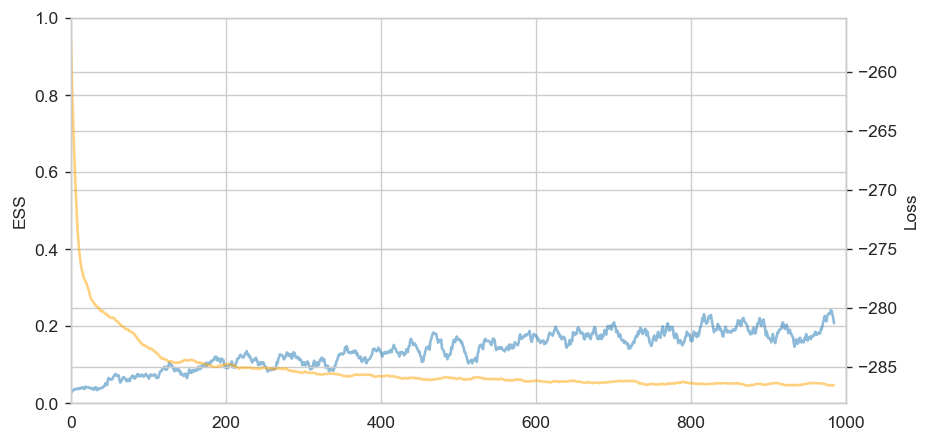

== Era 0 | Epoch 0 metrics ==
	loss -235.994
	logp 0.959931
	logq -235.034
	ess 0.0293993
== Era 1 | Epoch 0 metrics ==
	loss -277.303
	logp 66.6965
	logq -210.607
	ess 0.051622
== Era 2 | Epoch 0 metrics ==
	loss -284.387
	logp 80.6628
	logq -203.724
	ess 0.0889644
== Era 3 | Epoch 0 metrics ==
	loss -285.085
	logp 82.2701
	logq -202.815
	ess 0.109142
== Era 4 | Epoch 0 metrics ==
	loss -285.614
	logp 83.3408
	logq -202.273
	ess 0.113865
== Era 5 | Epoch 0 metrics ==
	loss -285.915
	logp 83.9784
	logq -201.937
	ess 0.139619
== Era 6 | Epoch 0 metrics ==
	loss -286.04
	logp 84.2286
	logq -201.811
	ess 0.150886
== Era 7 | Epoch 0 metrics ==
	loss -286.248
	logp 84.5875
	logq -201.66
	ess 0.172835
== Era 8 | Epoch 0 metrics ==
	loss -286.332
	logp 84.8448
	logq -201.488
	ess 0.178642
== Era 9 | Epoch 0 metrics ==
	loss -286.417
	logp 85.0049
	logq -201.412
	ess 0.196252


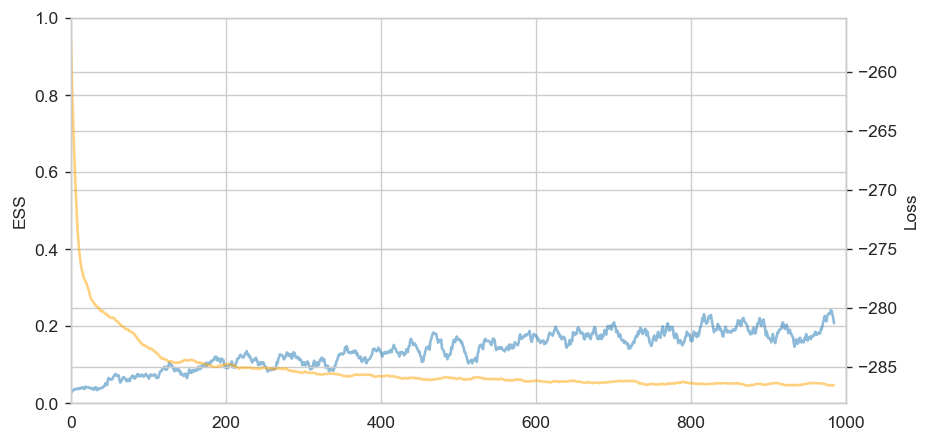

In [514]:
if not use_pretrained:
    [plt.close(plt.figure(fignum)) for fignum in plt.get_fignums()] # close all existing figures 
    live_plot = init_live_plot()
    for era in range(N_era):
        for epoch in range(N_epoch):
            train_step(model, u1_action, calc_dkl, optimizer, history)
            if epoch % print_freq == 0:
                print_metrics(history, avg_last_N_epochs=print_freq)
            if epoch % plot_freq == 0:
                update_plots(history, **live_plot) 
else:
    print('Skipping training')

In [515]:
print('Model weights blob:\n===')
serialized_model = io.BytesIO() 
torch.save(model['layers'].state_dict(), serialized_model) 
print(base64.b64encode(serialized_model.getbuffer()).decode('utf-8')) 
print('===')

Model weights blob:
===
UEsDBAAACAgAAAAAAAAAAAAAAAAAAAAAAAAQABIAYXJjaGl2ZS9kYXRhLnBrbEZCDgBaWlpaWlpaWlpaWlpaWoACY2NvbGxlY3Rpb25zCk9yZGVyZWREaWN0CnEAKVJxAShYHAAAADAucGxhcV9jb3VwbGluZy5uZXQuMC53ZWlnaHRxAmN0b3JjaC5fdXRpbHMKX3JlYnVpbGRfdGVuc29yX3YyCnEDKChYBwAAAHN0b3JhZ2VxBGN0b3JjaApGbG9hdFN0b3JhZ2UKcQVYAQAAADBxBlgDAAAAY3B1cQdLkHRxCFFLAChLCEsCSwNLA3RxCShLEksJSwNLAXRxColoAClScQt0cQxScQ1YGgAAADAucGxhcV9jb3VwbGluZy5uZXQuMC5iaWFzcQ5oAygoaARoBVgBAAAAMXEPaAdLCHRxEFFLAEsIhXERSwGFcRKJaAApUnETdHEUUnEVWBwAAAAwLnBsYXFfY291cGxpbmcubmV0LjIud2VpZ2h0cRZoAygoaARoBVgBAAAAMnEXaAdNQAJ0cRhRSwAoSwhLCEsDSwN0cRkoS0hLCUsDSwF0cRqJaAApUnEbdHEcUnEdWBoAAAAwLnBsYXFfY291cGxpbmcubmV0LjIuYmlhc3EeaAMoKGgEaAVYAQAAADNxH2gHSwh0cSBRSwBLCIVxIUsBhXEiiWgAKVJxI3RxJFJxJVgcAAAAMC5wbGFxX2NvdXBsaW5nLm5ldC40LndlaWdodHEmaAMoKGgEaAVYAQAAADRxJ2gHS9h0cShRSwAoSwNLCEsDSwN0cSkoS0hLCUsDSwF0cSqJaAApUnErdHEsUnEtWBoAAAAwLnBsYXFfY291cGxpbmcubmV0LjQuYmlhc3EuaAMoKGgEaAVYAQAAADVxL2gHSwN0cTBRSwBLA4VxMUsBhXEyiWgAKVJxM3RxNFJxNVgcAAAAMS5wbGFxX2NvdXBsaW5n

slope 1 linear regression S = S_eff + -286.4526


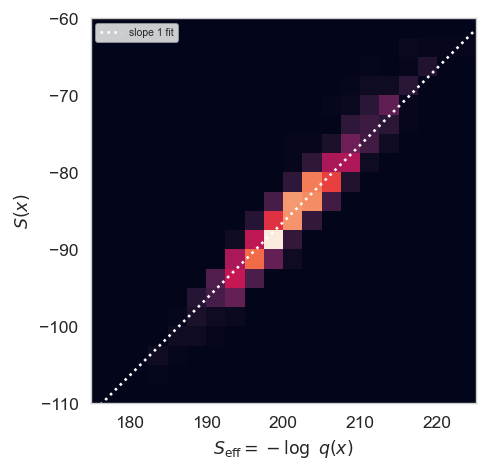

In [516]:
layers, prior = model['layers'], model['prior']
torch_x, torch_logq = apply_flow_to_prior(prior, layers, batch_size=1024)
S_eff = -grab(torch_logq)
S = grab(u1_action(torch_x))
fit_b = np.mean(S) - np.mean(S_eff)
print(f'slope 1 linear regression S = S_eff + {fit_b:.4f}') 
fig, ax = plt.subplots(1,1, dpi=125, figsize=(4,4)) 
ax.hist2d(S_eff, S, bins=20, range=[[175, 225], [-110, -60]]) 
ax.set_xlabel(r'$S_{\mathrm{eff}} = -\log~q(x)$') 
ax.set_ylabel(r'$S(x)$')
ax.set_aspect('equal')
xs = np.linspace(175, 225, num=4, endpoint=True)
ax.plot(xs, xs + fit_b, ':', color='w', label='slope 1 fit') 
plt.legend(prop={'size': 6})
plt.show()

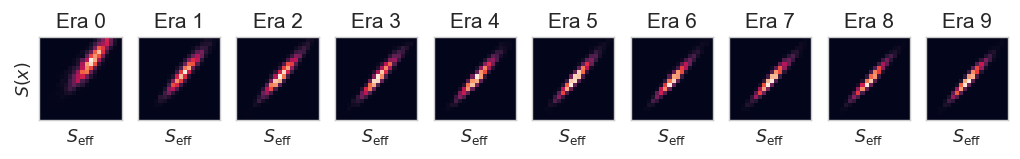

In [517]:
if not use_pretrained:
    fig, axes = plt.subplots(1, 10, dpi=125, sharey=True, figsize=(10, 1))
    logq_hist = np.array(history['logq']).reshape(N_era, -1)[::N_era//10] 
    logp_hist = np.array(history['logp']).reshape(N_era, -1)[::N_era//10] 
    for i, (ax, logq, logp) in enumerate(zip(axes, logq_hist, logp_hist)):
        ax.hist2d(-logq, -logp, bins=20, range=[[175, 225], [-110, -60]])
        if i == 0:
            ax.set_ylabel(r'$S(x)$') 
        ax.set_xlabel(r'$S_{\mathrm{eff}}$') 
        ax.set_title(f'Era {i * (N_era//10)}') 
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_aspect('equal') 
    plt.show()
else:
    print('Skipping plot because use_pretrained == True')

In [518]:
ensemble_size = 8192
u1_ens = make_mcmc_ensemble(model, u1_action, 64, ensemble_size) 
print("Accept rate:", np.mean(u1_ens['accepted']))

Accept rate: 0.2432861328125


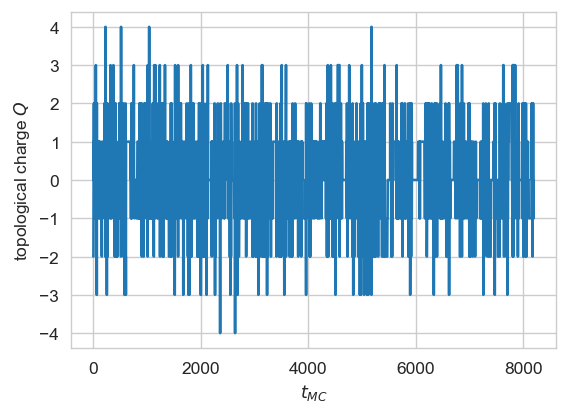

In [519]:
Q = grab(topo_charge(torch.stack(u1_ens['x'], axis=0))) 
plt.figure(figsize=(5,3.5), dpi=125)
plt.plot(Q)
plt.xlabel(r'$t_{MC}$')
plt.ylabel(r'topological charge $Q$') 
plt.show()

In [520]:
X_mean, X_err = bootstrap(Q**2, Nboot=100, binsize=16) 
print(f'Topological susceptibility = {X_mean:.2f} +/- {X_err:.2f}') 
print(f'... vs HMC estimate = 1.23 +/- 0.02')

Topological susceptibility = 1.21 +/- 0.05
... vs HMC estimate = 1.23 +/- 0.02


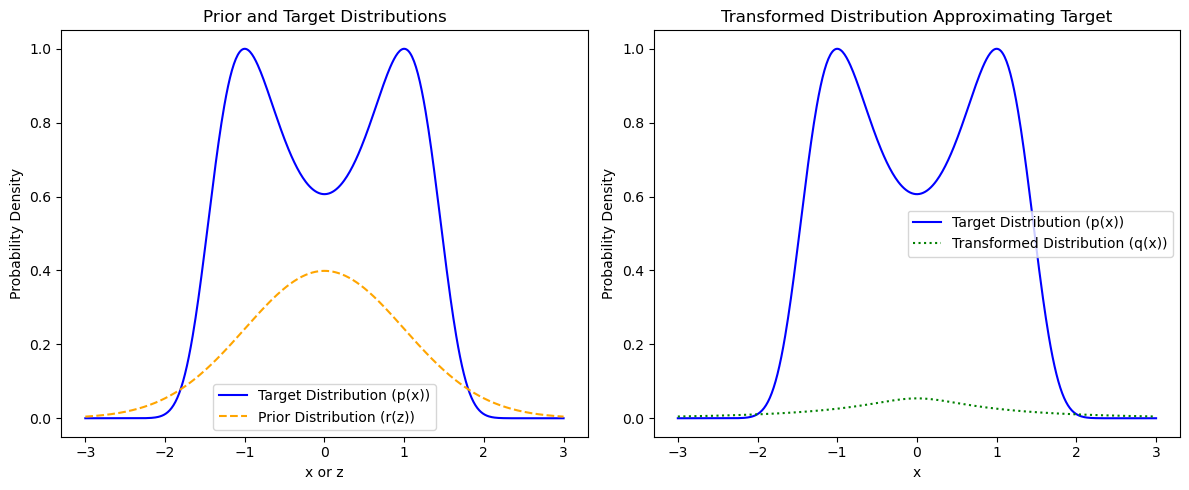

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# Define the target distribution (bimodal)
def target_distribution(x):
    return np.exp(-0.5 * (x**2 - 1)**2)

# Define the prior distribution (Gaussian)
def prior_distribution(z):
    return norm.pdf(z, loc=0, scale=1)

# Define the transformation function and its inverse
def transform(z):
    return z**3 - z

def inverse_transform(x):
    return np.sign(x) * np.sqrt(1 + np.sqrt(1 + 4 * x**2) / 2)

# Define the Jacobian determinant for the transform
def jacobian(z):
    return np.abs(3 * z**2 - 1)

# Generate a grid of values for plotting
x = np.linspace(-3, 3, 500)
z = np.linspace(-3, 3, 500)
transformed_z = transform(z)

# Calculate distributions
target = target_distribution(x)
prior = prior_distribution(z)
transformed_prior = prior_distribution(inverse_transform(x)) / jacobian(inverse_transform(x))

# Plot the distributions
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# Plot the prior and target distributions
ax[0].plot(x, target, label='Target Distribution (p(x))', color='blue')
ax[0].plot(z, prior, label='Prior Distribution (r(z))', color='orange', linestyle='dashed')
ax[0].legend()
ax[0].set_title("Prior and Target Distributions")
ax[0].set_xlabel("x or z")
ax[0].set_ylabel("Probability Density")

# Plot the transformed distribution
ax[1].plot(x, target, label='Target Distribution (p(x))', color='blue')
ax[1].plot(x, transformed_prior, label='Transformed Distribution (q(x))', color='green', linestyle='dotted')
ax[1].legend()
ax[1].set_title("Transformed Distribution Approximating Target")
ax[1].set_xlabel("x")
ax[1].set_ylabel("Probability Density")

plt.tight_layout()
plt.show()


Epoch 0: Loss = 0.5585625171661377
Epoch 100: Loss = -0.08985283225774765
Epoch 200: Loss = 0.3304154574871063
Epoch 300: Loss = 0.3009597361087799
Epoch 400: Loss = 0.22155548632144928
Epoch 500: Loss = 0.2432701140642166
Epoch 600: Loss = 0.6894310116767883
Epoch 700: Loss = 0.6673891544342041
Epoch 800: Loss = 0.5520653128623962
Epoch 900: Loss = 0.46046969294548035
Epoch 1000: Loss = 0.16324105858802795
Epoch 1100: Loss = 0.3046010434627533
Epoch 1200: Loss = 0.124707892537117
Epoch 1300: Loss = 0.22562986612319946
Epoch 1400: Loss = 0.19034142792224884
Epoch 1500: Loss = 0.19216333329677582
Epoch 1600: Loss = 0.2149181216955185
Epoch 1700: Loss = 0.26776123046875
Epoch 1800: Loss = 0.1955716609954834
Epoch 1900: Loss = 0.23055486381053925
Epoch 2000: Loss = 0.1886766403913498
Epoch 2100: Loss = 0.15969236195087433
Epoch 2200: Loss = 0.03693009912967682
Epoch 2300: Loss = -0.057216741144657135
Epoch 2400: Loss = 0.08792369067668915
Epoch 2500: Loss = 0.1838739663362503
Epoch 2600: 

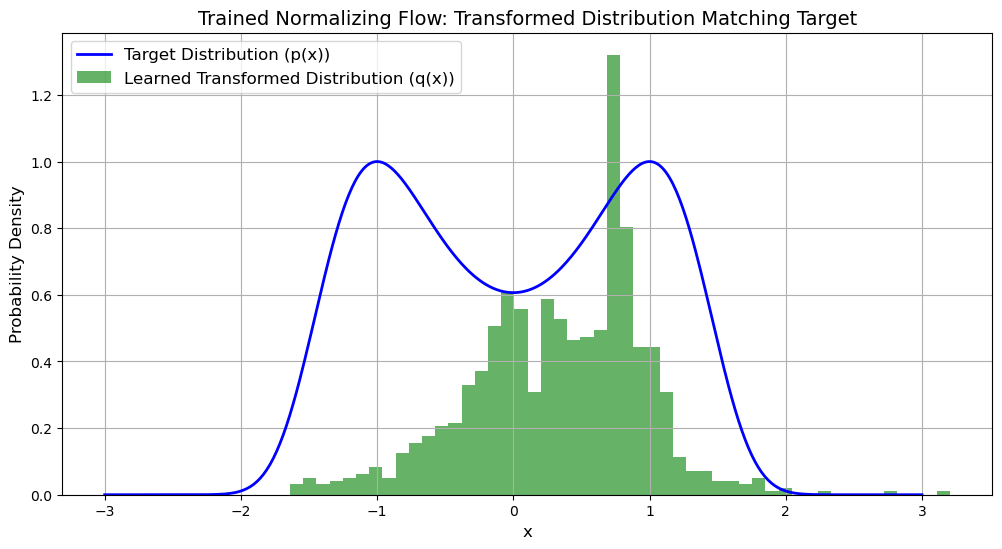

In [33]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim

# Target distribution (bimodal)
def target_distribution(x):
    return np.exp(-0.5 * (x**2 - 1)**2)

# Define the prior (Gaussian)
class PriorDistribution:
    def sample(self, n):
        return np.random.normal(0, 1, size=n)

    def log_prob(self, z):
        return -0.5 * z**2 - 0.5 * np.log(2 * np.pi)

# Define a simple flow (neural network)
class NormalizingFlow(nn.Module):
    def __init__(self):
        super(NormalizingFlow, self).__init__()
        self.fc1 = nn.Linear(1, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 1)
        self.tanh = nn.Tanh()

    def forward(self, z):
        h = torch.relu(self.fc1(z))
        h = torch.relu(self.fc2(h))
        h = self.fc3(h)
        return z + self.tanh(h)  # A simple residual flow

    def log_jacobian(self, z):
        h = torch.relu(self.fc1(z))
        h = torch.relu(self.fc2(h))
        h = self.fc3(h)
        jacobian = 1 + (1 - self.tanh(h)**2) * torch.autograd.grad(h.sum(), z, create_graph=True)[0]
        return torch.log(torch.abs(jacobian))

# Training the flow
n_samples = 1_000
prior = PriorDistribution()
flow = NormalizingFlow()
optimizer = optim.Adam(flow.parameters(), lr=0.001)

# Convert numpy to torch tensor
def torch_tensor(array):
    return torch.tensor(array, dtype=torch.float32).unsqueeze(-1)

z_samples = torch_tensor(prior.sample(n_samples))

for epoch in range(10_000):
    optimizer.zero_grad()

    # Forward pass
    z = z_samples.clone().detach().requires_grad_(True)
    x = flow(z)
    log_rz = prior.log_prob(z.detach().numpy())
    log_jacobian = flow.log_jacobian(z)

    # Log probability under q
    log_qx = torch.tensor(log_rz) - log_jacobian

    # Log probability under p
    log_px = torch.log(torch.tensor(target_distribution(x.detach().numpy())) + 1e-7)

    # Loss: reverse KL divergence
    loss = (log_px - log_qx).mean()
    loss.backward()
    optimizer.step()

    if epoch % 100 == 0:
        print(f"Epoch {epoch}: Loss = {loss.item()}")

# Generate the trained transformed distribution
x_vals = np.linspace(-3, 3, 500)
target_vals = target_distribution(x_vals)

# Sample from the trained flow
z_samples = torch_tensor(prior.sample(1000))
x_samples = flow(z_samples).detach().numpy()

# Plot the results
plt.figure(figsize=(12, 6))

# Plot the target distribution
plt.plot(x_vals, target_vals, label="Target Distribution (p(x))", color="blue", linewidth=2)

# Plot the transformed distribution as histogram
plt.hist(x_samples, bins=50, density=True, alpha=0.6, label="Learned Transformed Distribution (q(x))", color="green")

plt.title("Trained Normalizing Flow: Transformed Distribution Matching Target", fontsize=14)
plt.xlabel("x", fontsize=12)
plt.ylabel("Probability Density", fontsize=12)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()


In [10]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# Define the target distribution (bimodal)
def target_distribution(x):
    return np.exp(-0.5 * (x**2 - 1)**2)

# Define the prior distribution (Gaussian)
class PriorDistribution:
    def sample(self, n):
        return np.random.normal(0, 1, size=n)

    def log_prob(self, z):
        return -0.5 * z**2 - 0.5 * np.log(2 * np.pi)

# Define a single affine coupling layer
class AffineCoupling(nn.Module):
    def __init__(self, dim):
        super(AffineCoupling, self).__init__()
        self.scale_net = nn.Sequential(
            nn.Linear(dim // 2, 64), nn.ReLU(), nn.Linear(64, dim // 2)
        )
        self.translate_net = nn.Sequential(
            nn.Linear(dim // 2, 64), nn.ReLU(), nn.Linear(64, dim // 2)
        )

    def forward(self, x):
        x1, x2 = x.chunk(2, dim=1)
        scale = self.scale_net(x1)
        translate = self.translate_net(x1)
        x2 = x2 * torch.exp(scale) + translate
        return torch.cat([x1, x2], dim=1), scale.sum(dim=1)

    def inverse(self, x):
        x1, x2 = x.chunk(2, dim=1)
        scale = self.scale_net(x1)
        translate = self.translate_net(x1)
        x2 = (x2 - translate) * torch.exp(-scale)
        return torch.cat([x1, x2], dim=1)

# Define a normalizing flow with multiple coupling layers
class NormalizingFlow(nn.Module):
    def __init__(self, dim, n_layers):
        super(NormalizingFlow, self).__init__()
        self.layers = nn.ModuleList([AffineCoupling(dim) for _ in range(n_layers)])
    
    def forward(self, z):
        log_jacobian = torch.zeros(z.size(0))
        for layer in self.layers:
            z, log_det = layer(z)
            log_jacobian += log_det
        return z, log_jacobian

    def inverse(self, x):
        for layer in reversed(self.layers):
            x = layer.inverse(x)
        return x

# Train the normalizing flow
def train_flow(target, flow, prior, epochs=1000, batch_size=128, lr=1e-3):
    optimizer = optim.Adam(flow.parameters(), lr=lr)
    losses = []
    for epoch in range(epochs):
        z = torch.tensor(prior.sample(batch_size)).float().unsqueeze(-1)
        x, log_jacobian = flow(z)
        
        # Compute log probabilities
        log_rz = -0.5 * z**2 - 0.5 * np.log(2 * np.pi)
        log_px = torch.log(torch.tensor(target(x.detach().numpy())) + 1e-7)
        loss = (log_rz - log_jacobian - log_px).mean()

        # Optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        losses.append(loss.item())
        if epoch % 100 == 0:
            print(f"Epoch {epoch}: Loss = {loss.item()}")
    return losses

# Set parameters and train
dim = 2  # Input dimension for coupling
n_layers = 4  # Number of flow layers
batch_size = 128
flow = NormalizingFlow(dim, n_layers)
prior = PriorDistribution()

# Train the flow
losses = train_flow(target_distribution, flow, prior, epochs=1000, batch_size=batch_size)

# Plot training losses
plt.plot(losses)
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid()
plt.show()

# Visualize the trained flow
z_samples = torch.tensor(prior.sample(5000)).float().unsqueeze(-1)
x_samples, _ = flow(z_samples)
x_samples = x_samples.detach().numpy()

x_vals = np.linspace(-3, 3, 500)
target_vals = target_distribution(x_vals)

plt.hist(x_samples.flatten(), bins=50, density=True, alpha=0.5, label="Learned q(x)")
plt.plot(x_vals, target_vals, label="Target p(x)", color="blue")
plt.title("Trained Normalizing Flow: Final Transformed Distribution")
plt.xlabel("x")
plt.ylabel("Probability Density")
plt.legend()
plt.show()


ValueError: not enough values to unpack (expected 2, got 1)

Epoch 0: Loss = 0.33238840103149414
Epoch 100: Loss = -10.189445495605469
Epoch 200: Loss = -27.645442962646484
Epoch 300: Loss = -54.558074951171875
Epoch 400: Loss = -95.22618865966797
Epoch 500: Loss = nan
Epoch 600: Loss = nan
Epoch 700: Loss = nan
Epoch 800: Loss = nan
Epoch 900: Loss = nan


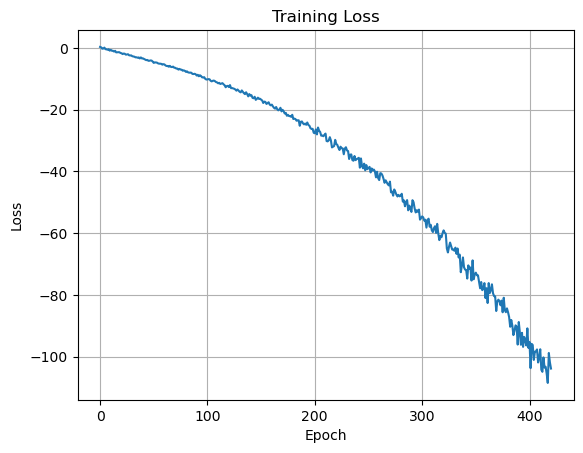

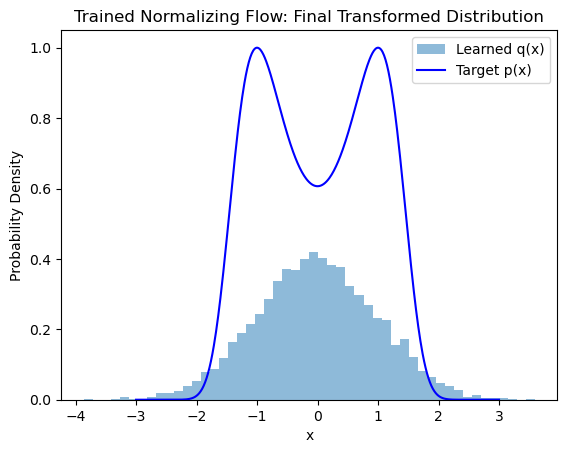

In [12]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# Define the target distribution (bimodal)
def target_distribution(x):
    return np.exp(-0.5 * (x**2 - 1)**2)

# Define the prior distribution (Gaussian)
class PriorDistribution:
    def sample(self, n):
        return np.random.normal(0, 1, size=n)

    def log_prob(self, z):
        return -0.5 * z**2 - 0.5 * np.log(2 * np.pi)

# Define a single affine coupling layer
class AffineCoupling(nn.Module):
    def __init__(self, dim):
        super(AffineCoupling, self).__init__()
        self.scale_net = nn.Sequential(
            nn.Linear(dim // 2, 64), nn.ReLU(), nn.Linear(64, dim // 2)
        )
        self.translate_net = nn.Sequential(
            nn.Linear(dim // 2, 64), nn.ReLU(), nn.Linear(64, dim // 2)
        )

    def forward(self, x):
        x1, x2 = x.chunk(2, dim=1)
        scale = self.scale_net(x1)
        translate = self.translate_net(x1)
        x2 = x2 * torch.exp(scale) + translate
        return torch.cat([x1, x2], dim=1), scale.sum(dim=1)

    def inverse(self, x):
        x1, x2 = x.chunk(2, dim=1)
        scale = self.scale_net(x1)
        translate = self.translate_net(x1)
        x2 = (x2 - translate) * torch.exp(-scale)
        return torch.cat([x1, x2], dim=1)

# Define a normalizing flow with multiple coupling layers
class NormalizingFlow(nn.Module):
    def __init__(self, dim, n_layers):
        super(NormalizingFlow, self).__init__()
        self.layers = nn.ModuleList([AffineCoupling(dim) for _ in range(n_layers)])
    
    def forward(self, z):
        log_jacobian = torch.zeros(z.size(0))
        for layer in self.layers:
            z, log_det = layer(z)
            log_jacobian += log_det
        return z, log_jacobian

    def inverse(self, x):
        for layer in reversed(self.layers):
            x = layer.inverse(x)
        return x

# Train the normalizing flow
def train_flow(target, flow, prior, epochs=1000, batch_size=128, lr=1e-3):
    optimizer = optim.Adam(flow.parameters(), lr=lr)
    losses = []
    for epoch in range(epochs):
        # Embed 1D samples into 2D
        z = torch.tensor(prior.sample(batch_size)).float().unsqueeze(-1)
        z = torch.cat([z, torch.zeros_like(z)], dim=1)  # Embed to 2D

        x, log_jacobian = flow(z)
        
        # Compute log probabilities
        log_rz = -0.5 * z[:, 0]**2 - 0.5 * np.log(2 * np.pi)  # Use the first dimension
        log_px = torch.log(torch.tensor(target(x[:, 0].detach().numpy())) + 1e-7)
        loss = (log_rz - log_jacobian - log_px).mean()

        # Optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        losses.append(loss.item())
        if epoch % 100 == 0:
            print(f"Epoch {epoch}: Loss = {loss.item()}")
    return losses

# Set parameters and train
dim = 2  # Embed to 2D for splitting
n_layers = 4  # Number of flow layers
batch_size = 128
flow = NormalizingFlow(dim, n_layers)
prior = PriorDistribution()

# Train the flow
losses = train_flow(target_distribution, flow, prior, epochs=1000, batch_size=batch_size)

# Plot training losses
plt.plot(losses)
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid()
plt.show()

# Visualize the trained flow
z_samples = torch.tensor(prior.sample(5000)).float().unsqueeze(-1)
z_samples = torch.cat([z_samples, torch.zeros_like(z_samples)], dim=1)  # Embed to 2D
x_samples, _ = flow(z_samples)
x_samples = x_samples[:, 0].detach().numpy()  # Use first dimension for visualization

x_vals = np.linspace(-3, 3, 500)
target_vals = target_distribution(x_vals)

plt.hist(x_samples, bins=50, density=True, alpha=0.5, label="Learned q(x)")
plt.plot(x_vals, target_vals, label="Target p(x)", color="blue")
plt.title("Trained Normalizing Flow: Final Transformed Distribution")
plt.xlabel("x")
plt.ylabel("Probability Density")
plt.legend()
plt.show()

Epoch 0: Loss = 0.6801647543907166
Epoch 100: Loss = -0.755811333656311
Epoch 200: Loss = -1.7233082056045532
Epoch 300: Loss = -2.1495771408081055
Epoch 400: Loss = -3.4010493755340576
Epoch 500: Loss = -4.42497444152832
Epoch 600: Loss = -5.510056972503662
Epoch 700: Loss = -6.830013751983643
Epoch 800: Loss = -8.142561912536621
Epoch 900: Loss = -8.359498023986816


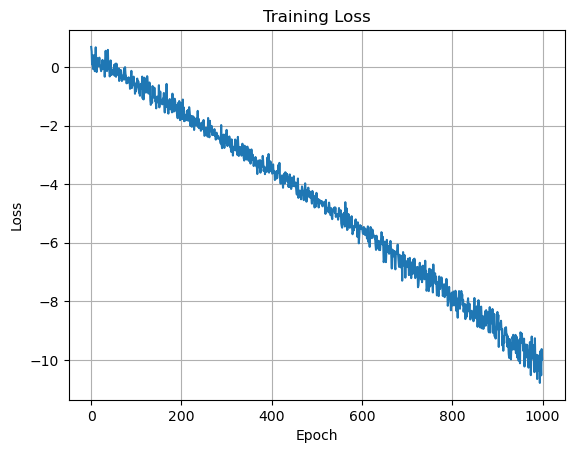

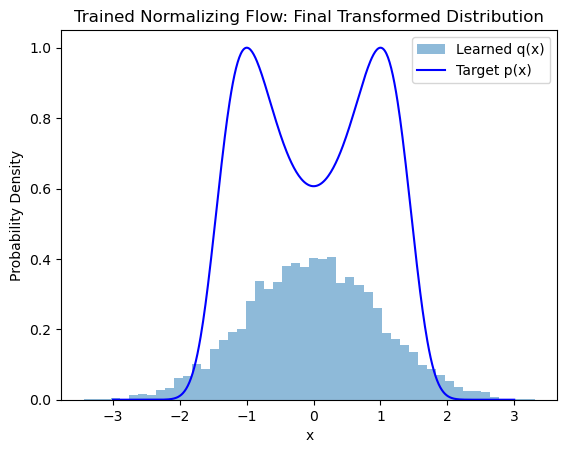

In [13]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# Target distribution (bimodal)
def target_distribution(x):
    return np.exp(-0.5 * (x**2 - 1)**2)

# Clipped target density to avoid numerical instability
def stable_target_distribution(x):
    density = target_distribution(x)
    return np.maximum(density, 1e-7)

# Prior distribution (Gaussian)
class PriorDistribution:
    def sample(self, n):
        return np.random.normal(0, 1, size=n)

    def log_prob(self, z):
        return -0.5 * z**2 - 0.5 * np.log(2 * np.pi)

# Single affine coupling layer
class AffineCoupling(nn.Module):
    def __init__(self, dim):
        super(AffineCoupling, self).__init__()
        self.scale_net = nn.Sequential(
            nn.Linear(dim // 2, 64), nn.ReLU(), nn.Linear(64, dim // 2)
        )
        self.translate_net = nn.Sequential(
            nn.Linear(dim // 2, 64), nn.ReLU(), nn.Linear(64, dim // 2)
        )

    def forward(self, x):
        x1, x2 = x.chunk(2, dim=1)
        scale = self.scale_net(x1)
        translate = self.translate_net(x1)
        x2 = x2 * torch.exp(scale) + translate
        return torch.cat([x1, x2], dim=1), scale.sum(dim=1)

    def inverse(self, x):
        x1, x2 = x.chunk(2, dim=1)
        scale = self.scale_net(x1)
        translate = self.translate_net(x1)
        x2 = (x2 - translate) * torch.exp(-scale)
        return torch.cat([x1, x2], dim=1)

# Normalizing flow
class NormalizingFlow(nn.Module):
    def __init__(self, dim, n_layers):
        super(NormalizingFlow, self).__init__()
        self.layers = nn.ModuleList([AffineCoupling(dim) for _ in range(n_layers)])
    
    def forward(self, z):
        log_jacobian = torch.zeros(z.size(0))
        for layer in self.layers:
            z, log_det = layer(z)
            log_jacobian += log_det
        return z, log_jacobian

    def inverse(self, x):
        for layer in reversed(self.layers):
            x = layer.inverse(x)
        return x

# Train the flow
def train_flow(target, flow, prior, epochs=1000, batch_size=128, lr=1e-4):
    optimizer = optim.Adam(flow.parameters(), lr=lr, weight_decay=1e-5)
    losses = []
    for epoch in range(epochs):
        z = torch.tensor(prior.sample(batch_size)).float().unsqueeze(-1)
        z = torch.cat([z, torch.zeros_like(z)], dim=1)  # Embed to 2D
        x, log_jacobian = flow(z)

        # Compute log probabilities
        log_rz = -0.5 * z[:, 0]**2 - 0.5 * np.log(2 * np.pi)
        log_px = torch.log(torch.tensor(stable_target_distribution(x[:, 0].detach().numpy())) + 1e-7)

        loss = (log_rz - log_jacobian - log_px).mean()

        # Gradient clipping
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(flow.parameters(), max_norm=5)
        optimizer.step()
        
        if torch.isnan(loss):
            print(f"NaN detected at epoch {epoch}!")
            break

        losses.append(loss.item())
        if epoch % 100 == 0:
            print(f"Epoch {epoch}: Loss = {loss.item()}")
    return losses

# Set parameters and train
dim = 2  # Embed to 2D
n_layers = 4  # Number of flow layers
batch_size = 64  # Smaller batch size
flow = NormalizingFlow(dim, n_layers)
prior = PriorDistribution()

# Train the flow
losses = train_flow(stable_target_distribution, flow, prior, epochs=1000, batch_size=batch_size)

# Plot training losses
plt.plot(losses)
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid()
plt.show()

# Visualize the trained flow
z_samples = torch.tensor(prior.sample(5000)).float().unsqueeze(-1)
z_samples = torch.cat([z_samples, torch.zeros_like(z_samples)], dim=1)  # Embed to 2D
x_samples, _ = flow(z_samples)
x_samples = x_samples[:, 0].detach().numpy()  # Use first dimension for visualization

x_vals = np.linspace(-3, 3, 500)
target_vals = target_distribution(x_vals)

plt.hist(x_samples.flatten(), bins=50, density=True, alpha=0.5, label="Learned q(x)")
plt.plot(x_vals, target_vals, label="Target p(x)", color="blue")
plt.title("Trained Normalizing Flow: Final Transformed Distribution")
plt.xlabel("x")
plt.ylabel("Probability Density")
plt.legend()
plt.show()


Epoch 0: Loss = -1.460586428642273
Epoch 100: Loss = -2.8072285652160645
Epoch 200: Loss = -3.270418882369995
Epoch 300: Loss = -4.820072650909424
Epoch 400: Loss = -6.051665782928467
Epoch 500: Loss = -7.260087490081787
Epoch 600: Loss = -8.371479988098145
Epoch 700: Loss = -9.51994800567627
Epoch 800: Loss = -10.844500541687012
Epoch 900: Loss = -12.510052680969238


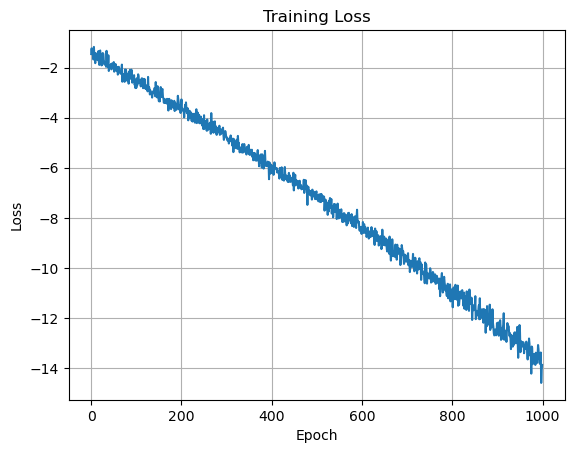

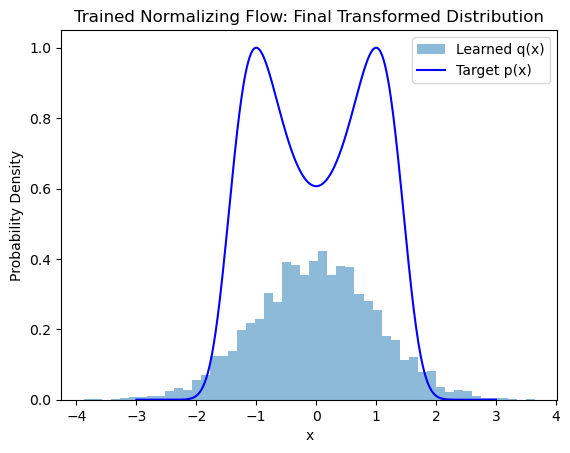

In [14]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# Target distribution (bimodal)
def target_distribution(x):
    return np.exp(-0.5 * (x**2 - 1)**2)

# Clipped target density to avoid numerical instability
def stable_target_distribution(x):
    density = target_distribution(x)
    return np.maximum(density, 1e-7)

# Prior distribution (Gaussian)
class PriorDistribution:
    def sample(self, n):
        return np.random.normal(0, 1, size=n)

    def log_prob(self, z):
        return -0.5 * z**2 - 0.5 * np.log(2 * np.pi)

# Single affine coupling layer
class AffineCoupling(nn.Module):
    def __init__(self, dim):
        super(AffineCoupling, self).__init__()
        self.scale_net = nn.Sequential(
            nn.Linear(dim // 2, 64), nn.ReLU(), nn.Linear(64, dim // 2)
        )
        self.translate_net = nn.Sequential(
            nn.Linear(dim // 2, 64), nn.ReLU(), nn.Linear(64, dim // 2)
        )

    def forward(self, x):
        x1, x2 = x.chunk(2, dim=1)
        scale = self.scale_net(x1)
        translate = self.translate_net(x1)
        x2 = x2 * torch.exp(scale) + translate
        return torch.cat([x1, x2], dim=1), scale.sum(dim=1)

    def inverse(self, x):
        x1, x2 = x.chunk(2, dim=1)
        scale = self.scale_net(x1)
        translate = self.translate_net(x1)
        x2 = (x2 - translate) * torch.exp(-scale)
        return torch.cat([x1, x2], dim=1)

# Normalizing flow
class NormalizingFlow(nn.Module):
    def __init__(self, dim, n_layers):
        super(NormalizingFlow, self).__init__()
        self.layers = nn.ModuleList([AffineCoupling(dim) for _ in range(n_layers)])
    
    def forward(self, z):
        log_jacobian = torch.zeros(z.size(0))
        for layer in self.layers:
            z, log_det = layer(z)
            log_jacobian += log_det
        return z, log_jacobian

    def inverse(self, x):
        for layer in reversed(self.layers):
            x = layer.inverse(x)
        return x

# Train the flow
def train_flow(target, flow, prior, epochs=1000, batch_size=128, lr=1e-4):
    optimizer = optim.Adam(flow.parameters(), lr=lr, weight_decay=1e-5)
    losses = []
    for epoch in range(epochs):
        z = torch.tensor(prior.sample(batch_size)).float().unsqueeze(-1)
        z = torch.cat([z, torch.zeros_like(z)], dim=1)  # Embed to 2D
        x, log_jacobian = flow(z)

        # Compute log probabilities correctly
        log_rz = -0.5 * z[:, 0]**2 - 0.5 * np.log(2 * np.pi)  # Prior log-prob
        log_px = torch.log(torch.tensor(stable_target_distribution(x[:, 0].detach().numpy())) + 1e-7)  # Target log-prob

        # Correct loss: log(q(x)) = log(r(z)) - log(|det(J)|)
        loss = (log_rz - log_jacobian - log_px).mean()

        # Gradient clipping
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(flow.parameters(), max_norm=5)
        optimizer.step()
        
        if torch.isnan(loss):
            print(f"NaN detected at epoch {epoch}!")
            break

        losses.append(loss.item())
        if epoch % 100 == 0:
            print(f"Epoch {epoch}: Loss = {loss.item()}")
    return losses

# Set parameters and train
dim = 2  # Embed to 2D
n_layers = 4  # Number of flow layers
batch_size = 64  # Smaller batch size
flow = NormalizingFlow(dim, n_layers)
prior = PriorDistribution()

# Train the flow
losses = train_flow(stable_target_distribution, flow, prior, epochs=1000, batch_size=batch_size)

# Plot training losses
plt.plot(losses)
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid()
plt.show()

# Visualize the trained flow
z_samples = torch.tensor(prior.sample(5000)).float().unsqueeze(-1)
z_samples = torch.cat([z_samples, torch.zeros_like(z_samples)], dim=1)  # Embed to 2D
x_samples, _ = flow(z_samples)
x_samples = x_samples[:, 0].detach().numpy()  # Use first dimension for visualization

x_vals = np.linspace(-3, 3, 500)
target_vals = target_distribution(x_vals)

plt.hist(x_samples.flatten(), bins=50, density=True, alpha=0.5, label="Learned q(x)")
plt.plot(x_vals, target_vals, label="Target p(x)", color="blue")
plt.title("Trained Normalizing Flow: Final Transformed Distribution")
plt.xlabel("x")
plt.ylabel("Probability Density")
plt.legend()
plt.show()


/var/folders/ns/x0vvs1s15bb4wkzknj03y9k40000gn/T/ipykernel_21589/2169646883.py:77: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  log_rz = torch.tensor(-0.5 * z[:, 0]**2 - 0.5 * np.log(2 * np.pi))  # Prior log-prob


Epoch 0: Loss = 0.2058582603931427
Epoch 100: Loss = -0.3695705235004425
Epoch 200: Loss = -1.278214693069458
Epoch 300: Loss = -2.766309976577759
Epoch 400: Loss = -2.8535819053649902
Epoch 500: Loss = -4.278975486755371
Epoch 600: Loss = -5.041645050048828
Epoch 700: Loss = -6.169564723968506
Epoch 800: Loss = -6.9785685539245605
Epoch 900: Loss = -10.09135913848877


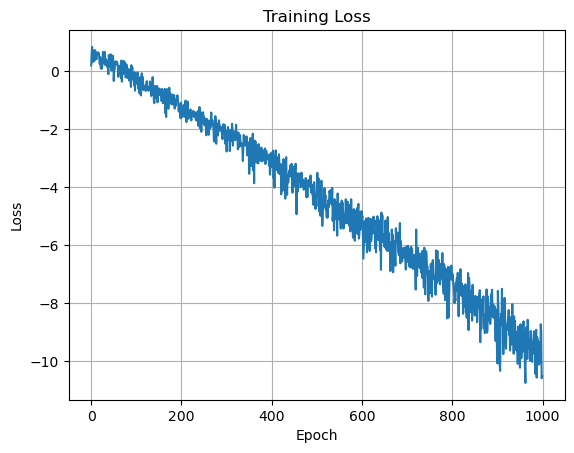

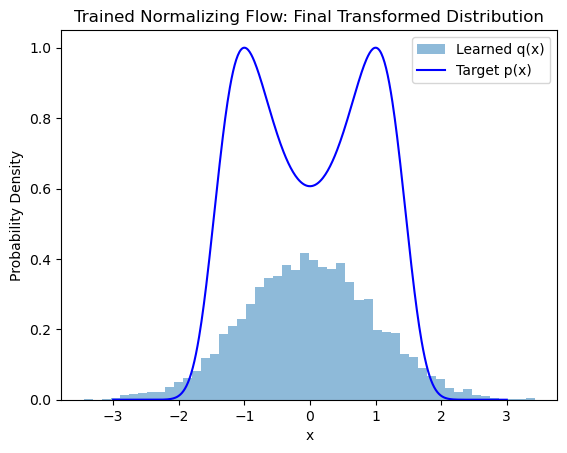

In [29]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# Target distribution (bimodal)
def target_distribution(x):
    return np.exp(-0.5 * (x**2 - 1)**2)

# Clipped target density to avoid numerical instability
def stable_target_distribution(x):
    density = target_distribution(x)
    return np.maximum(density, 1e-7)

# Prior distribution (Gaussian)
class PriorDistribution:
    def sample(self, n):
        return np.random.normal(0, 1, size=n)

    def log_prob(self, z):
        return -0.5 * z**2 - 0.5 * np.log(2 * np.pi)

# Single affine coupling layer
class AffineCoupling(nn.Module):
    def __init__(self, dim):
        super(AffineCoupling, self).__init__()
        self.scale_net = nn.Sequential(
            nn.Linear(dim // 2, 64), nn.ReLU(), nn.Linear(64, dim // 2)
        )
        self.translate_net = nn.Sequential(
            nn.Linear(dim // 2, 64), nn.ReLU(), nn.Linear(64, dim // 2)
        )

    def forward(self, x):
        x1, x2 = x.chunk(2, dim=1)
        scale = self.scale_net(x1)
        translate = self.translate_net(x1)
        x2 = x2 * torch.exp(scale) + translate
        return torch.cat([x1, x2], dim=1), scale.sum(dim=1)

    def inverse(self, x):
        x1, x2 = x.chunk(2, dim=1)
        scale = self.scale_net(x1)
        translate = self.translate_net(x1)
        x2 = (x2 - translate) * torch.exp(-scale)
        return torch.cat([x1, x2], dim=1)

# Normalizing flow
class NormalizingFlow(nn.Module):
    def __init__(self, dim, n_layers):
        super(NormalizingFlow, self).__init__()
        self.layers = nn.ModuleList([AffineCoupling(dim) for _ in range(n_layers)])
    
    def forward(self, z):
        log_jacobian = torch.zeros(z.size(0))
        for layer in self.layers:
            z, log_det = layer(z)
            log_jacobian += log_det
        return z, log_jacobian

    def inverse(self, x):
        for layer in reversed(self.layers):
            x = layer.inverse(x)
        return x

# Train the flow
def train_flow(target, flow, prior, epochs=1000, batch_size=128, lr=1e-4):
    optimizer = optim.Adam(flow.parameters(), lr=lr, weight_decay=1e-5)
    losses = []
    for epoch in range(epochs):
        z = torch.tensor(prior.sample(batch_size)).float().unsqueeze(-1)
        z = torch.cat([z, torch.zeros_like(z)], dim=1)  # Embed to 2D
        x, log_jacobian = flow(z)

        # Compute log probabilities correctly
        log_rz = torch.tensor(-0.5 * z[:, 0]**2 - 0.5 * np.log(2 * np.pi))  # Prior log-prob
        log_px = torch.log(torch.tensor(stable_target_distribution(x[:, 0].detach().numpy())) + 1e-7)  # Target log-prob

        # Correct loss: log(q(x)) = log(r(z)) - log(|det(J)|)
        loss = (log_px - log_rz - log_jacobian).mean()

        # Check for NaN or Inf values in loss
        if torch.isnan(loss) or torch.isinf(loss):
            print(f"NaN/Inf detected at epoch {epoch}!")
            break

        # Gradient clipping to avoid instability
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(flow.parameters(), max_norm=5)
        optimizer.step()
        
        losses.append(loss.item())
        if epoch % 100 == 0:
            print(f"Epoch {epoch}: Loss = {loss.item()}")
    return losses

# Set parameters and train
dim = 2  # Embed to 2D
n_layers = 4  # Number of flow layers
batch_size = 64  # Smaller batch size
flow = NormalizingFlow(dim, n_layers)
prior = PriorDistribution()

# Train the flow
losses = train_flow(stable_target_distribution, flow, prior, epochs=1000, batch_size=batch_size)

# Plot training losses
plt.plot(losses)
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid()
plt.show()

# Visualize the trained flow
z_samples = torch.tensor(prior.sample(5000)).float().unsqueeze(-1)
z_samples = torch.cat([z_samples, torch.zeros_like(z_samples)], dim=1)  # Embed to 2D
x_samples, _ = flow(z_samples)
x_samples = x_samples[:, 0].detach().numpy()  # Use first dimension for visualization

x_vals = np.linspace(-3, 3, 500)
target_vals = target_distribution(x_vals)

plt.hist(x_samples.flatten(), bins=50, density=True, alpha=0.5, label="Learned q(x)")
plt.plot(x_vals, target_vals, label="Target p(x)", color="blue")
plt.title("Trained Normalizing Flow: Final Transformed Distribution")
plt.xlabel("x")
plt.ylabel("Probability Density")
plt.legend()
plt.show()


In [26]:
(log_px - log_rz).mean()

tensor(0.2222)

tensor([[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]], grad_fn=<LogBackward0>)